<a href="https://colab.research.google.com/github/amdeyk/ii_scproj/blob/main/DeepLabV3%2B_Lungs_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

Semantic segmentation is a computer vision task that involves dividing an image into different regions, each of which is labeled with a semantic category. The goal of semantic segmentation is to enable machines to understand the content of an image at a pixel level, by assigning a label to each individual pixel based on the object or region it belongs to.

This technique is widely used in many applications such as self-driving cars, medical image analysis, and object recognition in robotics. It helps to extract meaningful information from images and to understand the relationships between objects and their environment.

The below figure shows how semantic segmentation differs from other algorithms, such as object detection.

<br>
<img src='https://cdn.extras.talentsprint.com/AIandMLOps/Images/semantic_segmentation.png' width=700px>
<br><br>

Moreover, in contrast to object detection, which detects and localizes objects within an image, semantic segmentation is more precise and detailed. It provides a much more granular understanding of the content of an image, allowing for more advanced and accurate applications.

### Dataset

*  The dataset is made up of images and segmentated mask from two diffrent sources- Shenzhen and Montgomery dataset
*  The CXR_png folder consists of Chest X-Rays and the masks folder has the segmented mask
*  There are 704 images with their masks mapped with each other  



### Problem Statement
Perfrom the lungs segmentation on Chest X-Ray dataset using DeepLabV3+ model.

In [87]:
# #@title Download the data
# !wget https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/LungSegmentation.zip
# !unzip -qq LungSegmentation.zip
# print("Data Downloaded Successfuly!!")

### Import required packages

In [88]:
import os
import cv2
import numpy as np
import glob
from glob import glob
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [89]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

### Data Visualization (1 point)

#### Image Visualization
Visualize one of the Chest X-Ray image and its segmented label image.

In [90]:
# Visualize an image
# YOUR CODE HERE
# Set the directory paths
img_dir = '/content/LungSegmentation/CXR_png'
mask_dir = '/content/LungSegmentation/masks'

# List all the files in the directory
img_files = os.listdir(img_dir)
mask_files = os.listdir(mask_dir)

# Read an image and the corresponding mask
img = cv2.imread(os.path.join(img_dir, img_files[0]))
mask = cv2.imread(os.path.join(mask_dir, mask_files[0]))

# Convert the image and mask to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

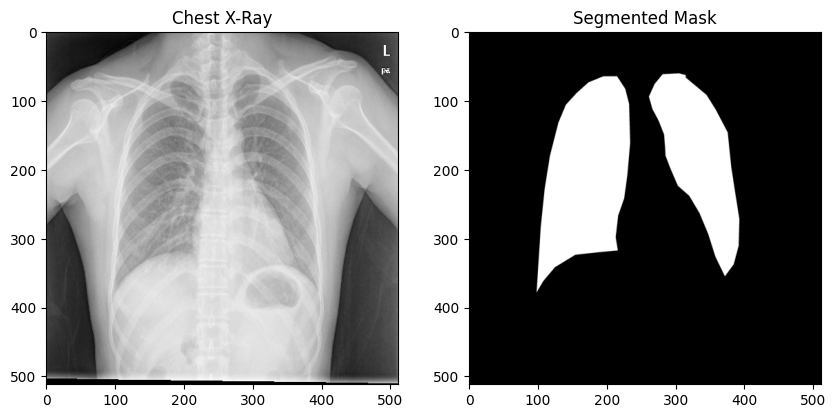

In [91]:
# Visualize a semantic part segmentation label image
# YOUR CODE HERE
# Display the image and mask
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.title('Chest X-Ray')
plt.subplot(1,2,2)
plt.imshow(mask_gray, cmap='gray')
plt.title('Segmented Mask')
plt.show()

### Create a TensorFlow Dataset (1 points)
Use the image size, batch size, number of classes, and data directory as given in the below code cell.

Hint: 
1. Find all the image files in the CXR_png and masks subdirectory separately. The resulting list should be sorted in ascending order.
2. Create a list of validation image, validation masks, test image, test masks, etc.
3. Create a function that reads an image file and returns a preprocessed image tensor.  

In [92]:
# Define constants for the image segmentation task.
# IMAGE_SIZE: the height and width of the images. All images will be resized to this size.
# BATCH_SIZE: the number of samples to process at a time. This is a hyperparameter that can be tuned.
# NUM_CLASSES: the number of classes in the segmentation task. In this case, there are two classes (presumably lung tissue and non-lung tissue).
# DATA_DIR: the directory where the dataset is located.
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 2
DATA_DIR = "./LungSegmentation"

from glob import glob

# Define the directories that contain the image files (*.png) and the segmentation mask files.
# '/content/LungSegmentation/CXR_png/' is the directory with the image files.
# '/content/LungSegmentation/masks/' is  the directory with the mask files.
img_dir = '/content/LungSegmentation/CXR_png/*.png'
mask_dir = '/content/LungSegmentation/masks/*.png'

# Use the glob function to get a list of all the image and mask file paths.
# The glob function returns a list of file paths that match the given pattern.
# The sorted function ensures the files are in a consistent order.
img_files = sorted(glob(img_dir))
mask_files = sorted(glob(mask_dir))


In [93]:
# Determine the indices at which to split the data.
# Here, the data is split into 70% for training, 15% for validation, and 15% for testing.
# The int function is used to round down to the nearest whole number.
train_idx = int(0.7 * len(img_files))
val_idx = int(0.85 * len(img_files))

# Split the image files into training, validation, and test sets based on the indices.
# The slice notation [start:end] is used to get a portion of the list.
# The start index is inclusive and the end index is exclusive.
train_img_files = img_files[:train_idx]
val_img_files = img_files[train_idx:val_idx]
test_img_files = img_files[val_idx:]

# Similarly, split the mask files into training, validation, and test sets.
train_mask_files = mask_files[:train_idx]
val_mask_files = mask_files[train_idx:val_idx]
test_mask_files = mask_files[val_idx:]


In [94]:
# Function to preprocess the images
def preprocess_image(img_path, img_size=512):
    # Read the image file
    # tf.io.read_file function reads the entire contents of an input filename.
    img = tf.io.read_file(img_path)

    # Decode the image
    # tf.image.decode_png function decodes a PNG-encoded image to a uint8 or uint16 tensor.
    # The channels argument is set to 1, which means we want to output grayscale images.
    img = tf.image.decode_png(img, channels=1)

    # Repeat the single channel image across three channels
    # Some neural networks require RGB input, so we duplicate our single grayscale channel across three channels.
    img = tf.repeat(img, [3], axis=-1)

    # Resize the image
    # tf.image.resize function resizes images to a specified size.
    # Here, the size is set to the constant defined at the beginning (512).
    img = tf.image.resize(img, [img_size, img_size])

    # Normalize the image to the range [0, 1]
    # Neural networks often work best with input data in a consistent range, like [0, 1].
    # This line scales the pixel values from the range [0, 255] (common in images) to [0, 1].
    img = img / 255.0

    return img



Create a **load_data** function that takes in two arguments, **image_list** and **mask_list**, which are lists of file paths to the images and corresponding masks, respectively. It then reads in the image and mask using the **read_image** function defined earlier. The function returns a tuple of **image** and **mask**.

In [95]:
def preprocess_mask(mask_path, img_size=512):
    # Similar to preprocess_image, but for masks.
    # Masks are already grayscale (no need to repeat channels here).

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [img_size, img_size])
    mask = mask / 255.0
    return mask

def load_and_preprocess_data(img_path, mask_path, img_size=512, mask_size=512):
    # This function loads and preprocesses an image-mask pair.
    # It ensures that the image and mask have the same size.

    img = preprocess_image(img_path, img_size=img_size)
    mask = preprocess_mask(mask_path, img_size=mask_size)
    
    if img.shape[:2] != mask.shape[:2]:
        raise ValueError(f"Image and mask sizes do not match: {img.shape} vs {mask.shape}")
    
    return img, mask

def load_data(image_list, mask_list, batch_size=4):
    # This function creates a TensorFlow dataset from the image and mask file paths.
    # It applies load_and_preprocess_data to each image-mask pair,
    # batches the data, and prefetches it for efficient GPU utilization.

    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_and_preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset



Create a **data_generator** function that takes in **image_list** and **mask_list** as arguments. 

In [96]:
# Function to generate the data in a suitable format for model training/validation/testing
def data_generator(image_list, mask_list, batch_size=4):
    # Create a tf.data.Dataset object with data and its corresponding labels
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))

    # Preprocess the images and masks in parallel
    # The lambda function applies the preprocessing functions to each image-mask pair
    dataset = dataset.map(lambda img, mask: (preprocess_image(img), preprocess_mask(mask)), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Combine consecutive elements of the dataset into batches
    dataset = dataset.batch(batch_size)

    # Prefetching overlaps the preprocessing and model execution of a training step
    # Fetching batches for the next step while the model is executing training step
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset



train_dataset = data_generator(train_img_files, train_mask_files, batch_size=4)
val_dataset = data_generator(val_img_files, val_mask_files, batch_size=4)
test_dataset = data_generator(test_img_files, test_mask_files, batch_size=4)




In [97]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>

Check the total images for train and validation.

In [98]:
# YOUR CODE HERE
print("Total training images: ", len(train_img_files))
print("Total validation images: ", len(val_img_files))

Total training images:  492
Total validation images:  106


Check the number of batches formed in train and validation set.


In [99]:
# YOUR CODE HERE
# I have used the cardinality method of a tf.data.Dataset, which returns the number of batches in the dataset
print("Total training batches: ", train_dataset.cardinality().numpy())
print("Total validation batches: ", val_dataset.cardinality().numpy())

# train_dataset.cardinality().numpy() returns the total number of batches in the training dataset, 
# and val_dataset.cardinality().numpy() returns the total number of batches in the validation dataset. 
# This is a useful check to understand the size of your dataset in terms of the number of batches, 
# especially considering the batch size you have 

Total training batches:  123
Total validation batches:  27


Now, we have created our TensorFlow Dataset. Further, let us try to understand the DeepLabV3+ model.

### Building the DeepLabV3+ model

Downsampling is widely adopted in deep convolutional neural networks (CNN) for reducing memory consumption while preserving the transformation invariance to some degree.

Multiple downsampling of a CNN will lead the feature map resolution to become smaller, resulting in lower prediction accuracy and loss of boundary information in semantic segmentation. 

DeepLabv3+ helps in solving these issues by including **atrous convolutions**. They aggregate context around a feature which helps in segmenting it better.

<br>

#### **Atrous Convolution/Dilated Convolution**

It is a tool for refining the effective field of view of the convolution. It modifies the field of view using a parameter termed ***atrous rate*** or ***dilation rate***.

With dilated convolution, as we go deeper in the network, we can keep the stride constant but with larger field-of-view without increasing the number of parameters or the amount of computation. It also enables larger output feature maps, which is useful for semantic segmentation.

In the below figure, Atrous/Dilated Convolution has wider field of view with same number of parameters as Normal convolution.

<br>
<img src="https://hasty.ai/media/pages/docs/mp-wiki/model-architectures/deeplabv3/261a269bc2-1638356334/image-52.webp" width=500px>
<br><br>



#### **DeepLabv3+**

Earlier version, DeepLabv3 has a problem of consuming too much time to process high-resolution images. DeepLabv3+ is a semantic segmentation architecture that improves upon DeepLabv3 with several improvements, such as adding an effective decoder module to refine the segmentation results.

The below figure shows the typical architecture of DeepLabv3+. The encoder module processes multiscale contextual information by applying dilated/atrous convolution at multiple scales, while the decoder module refines the segmentation results along object boundaries.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/deeplabv3_plus_model.png" width=1000px>
<br><br>

Deeplabv3+ employs Aligned Xception network as its main feature extractor (encoder), although with substantial modifications. Depth-wise separable convolution replaces all max pooling procedures.

In Model Playground, we can select feature extraction (encoding) network to use as either **Resnet** or EfficientNet.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the sampling rate becomes larger, the number of valid filter weights (i.e., weights that are applied to the valid feature region, instead of padded zeros) becomes smaller.


### Create the model (5 points) 
First, create different functions  to implement DeepLabV3+ architecture.



Create a function, **convolution_block()**, to add a convolution layer, a BatchNormalization layer, and apply ReLu activation in one go.

In [100]:
import tensorflow.keras as keras
# YOUR CODE HERE
def convolution_block(x, filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=True, dilation_rate=1):
    # Conv2D layer applies 2D convolution to the input
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, dilation_rate=dilation_rate)(x)
    
    # BatchNormalization layer normalizes the activations of the previous layer
    x = BatchNormalization()(x)
    
    # Activation layer applies the activation function (ReLU) to the output of the BatchNormalization layer
    if activation:
        x = Activation('relu')(x)
    
    return x




Create another function to perform **Dilated Spatial Pyramid Pooling**. Use above function to add different convolution blocks.

In [101]:
# YOUR CODE HERE
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import AveragePooling2D, Conv2D, BatchNormalization, Activation, UpSampling2D

def dspp_block(x, filters):
    # Apply average pooling to capture global context
    image_pool = AveragePooling2D(pool_size=(x.shape[1], x.shape[2]))(x)
    # Apply 1x1 convolution to the pooled features
    image_pool = Conv2D(filters, kernel_size=(1, 1), padding='same')(image_pool)
    # Normalize the activations
    image_pool = BatchNormalization()(image_pool)
    # Apply ReLU activation
    image_pool = Activation('relu')(image_pool)
    # Upsample to the original spatial dimensions
    image_pool = UpSampling2D((x.shape[1], x.shape[2]), interpolation="bilinear")(image_pool)

    # Apply convolution blocks with different dilation rates
    conv_block_1 = convolution_block(x, filters, kernel_size=(1, 1), padding='same')
    conv_block_2 = convolution_block(x, filters, kernel_size=(3, 3), dilation_rate=6, padding='same')
    conv_block_3 = convolution_block(x, filters, kernel_size=(3, 3), dilation_rate=12, padding='same')
    conv_block_4 = convolution_block(x, filters, kernel_size=(3, 3), dilation_rate=18, padding='same')

    # Concatenate the outputs of the average pooling and convolution blocks
    out = Concatenate()([image_pool, conv_block_1, conv_block_2, conv_block_3, conv_block_4])

    return out



The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features from the network backbone that have the same spatial resolution. Here, we use a **ResNet50** pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

##### Exploring ResNet-50 architecture before using it.

In [102]:
res_input = keras.Input(shape=(512, 512, 3))
resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor = res_input)

# Layers present in ResNet-50 network
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

From the above layers, 

- Use the low-level features from the `conv2_block3_2_relu` layer of the ResNet-50 network to fead in Decoder.

- Use the features from the `conv4_block6_2_relu` layer of the ResNet-50 to fead in Dilated Spatial Pyramid Pooling module.

#### Create Encoder
Create a function to implement the architecture for Encoder block. Use **ResNet50** pretrained on ImageNet as the backbone network. Use the features from the **conv4_block6_2_relu** layer of the backbone to fead in Dilated Spatial Pyramid Pooling module. Then return the backbone network along with encoder output.

In [103]:
# YOUR CODE HERE
from tensorflow.keras.applications import ResNet50

def create_encoder(input_shape, dspp_filters=256):
    # Define the input layer
    inputs = keras.Input(shape=input_shape)
    # inputs = keras.Input(shape=input_shape): This line of code is defining the input layer for the network. 
    # The shape argument is set to input_shape which is an argument passed to the function create_encoder. 
    # In this case, it is (512, 512, 3), referring to an image of size 512x512 pixels with 3 color channels (RGB).

    # Load the pre-trained ResNet50 model
    resnet50 = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    # Extract the features from the conv4_block6_2_relu layer
    high_level_features = resnet50.get_layer('conv4_block6_out').output
    # high_level_features = resnet50.get_layer('conv4_block6_out').output: 
    # This line extracts the output of the 'conv4_block6_out' layer from the pretrained ResNet50 model. 
    # The features from this layer will be sent into the DeepLabV3+ atrous spatial pyramid pooling (ASPP) 
    # module, also known as the DSPP block.
    
    # Apply the DSPP module to the high-level features
    encoder_output = dspp_block(high_level_features, filters=dspp_filters)
    # encoder_output = dspp_block(high_level_features, filters=dspp_filters): The extracted high level 
    # features from the ResNet50 model are then passed into the DSPP block (ASPP module). This block applies a series of 
    # convolutions with different dilation rates (gap sizes), which allow the model to capture multi-scale information.

    # Create a new model that includes the ResNet50 backbone and the DSPP module
    model = keras.Model(inputs=inputs, outputs=encoder_output)
    # The inputs=inputs argument specifies the input to the model, which in 
    # this case is the tensor created at the beginning of the create_encoder function with 
    # inputs = keras.Input(shape=input_shape).
    # The outputs=encoder_output argument specifies what the output of the model should be. 
    # In this case, encoder_output is the output of the atrous spatial pyramid pooling (ASPP) module, 
    # or DSPP block, which is designed to capture multi-scale information in the input images.



    return model, encoder_output

encoder_model, encoder_output = create_encoder((512, 512, 3))

### **PART-B**

#### Create Decoder

Create a function to implement the architecture for Decoder block. The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features (the **conv2_block3_2_relu** layer) from the network backbone that have the same spatial resolution. 

In [104]:
# YOUR CODE HERE
# The decoder's role is to recover the fine-grained details and spatial dimensions that were reduced in the encoding stage.

def create_decoder(encoder_model, encoder_output, decoder_filters=48):
    # Get the low-level features from the conv2_block3_2_relu layer
    low_level_features = encoder_model.get_layer('conv2_block3_out').output
    # This line is extracting low-level features from the encoder model, specifically from the output of the 'conv2_block3_out' layer of the ResNet50 backbone

    # Bilinearly upsample the encoder output by a factor of 4
    upsampled_encoder_output = keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(encoder_output)
    # Here, the high-level features from the encoder are being upsampled by a factor of 4 using bilinear interpolation. 
    # This is the first step of recovering the spatial information that was lost in the encoder.

    # Reduce the number of channels in the low-level features to make it compatible with the upsampled encoder output
    reduced_low_level_features = convolution_block(low_level_features, decoder_filters, kernel_size=(1, 1))
    # The low-level features have many channels, which can make concatenation with the upsampled high-level 
    # features computationally expensive. To mitigate this, the low-level features undergo a 1x1 convolution to reduce the number of channels.

    # Concatenate the upsampled encoder output and the reduced low-level features
    decoder_output = keras.layers.Concatenate()([upsampled_encoder_output, reduced_low_level_features])
    # The upsampled high-level features and reduced low-level features are concatenated to form the output of the decoder. 
    # This gives the decoder output both high-level semantic information and low-level spatial details, which is ideal for a segmentation task.
    
    return decoder_output


decoder_output = create_decoder(encoder_model, encoder_output)


#### Building full architecture of the Model

Write a function that combines the encoder and decoder functions defined above to create & implement a complete  DeepLabV3+ architecture.

In [105]:
# YOUR CODE HERE
def create_deeplabv3plus(input_shape, num_classes, dspp_filters=256, decoder_filters=48):
    # Create the encoder
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import UpSampling2D
    encoder_model, encoder_output = create_encoder(input_shape, dspp_filters=dspp_filters)
    # This line is calling the previously defined create_encoder function to create the encoder
    # part of the model, which is responsible for extracting high-level semantic features from the input images.

    # Create the decoder
    decoder_output = create_decoder(encoder_model, encoder_output, decoder_filters=decoder_filters)
    # This line is calling the create_decoder function to create the decoder part of the model. 
    # The decoder takes the output from the encoder and upsamples it to regain spatial resolution.

    # Add a convolutional layer to reduce the number of channels to the number of classes
    output = keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(decoder_output)
    # A convolutional layer with a 1x1 kernel size is added on top of the decoder output to reduce the number of 
    # channels to the number of classes. This is also known as a 1x1 convolutional classifier. 
    # It uses softmax activation because this is a multi-class segmentation problem.

    # Assuming that `model` is the model you got from `create_deeplabv3plus`
    output = UpSampling2D(size=(4, 4))(output)  # Adjust the size as needed
    # The model's output is further upsampled by a factor of 4 using 
    # bilinear interpolation to match the dimensions of the original input image.
    
    # Create the model
    model = keras.Model(inputs=encoder_model.input, outputs=output)
    # Finally, a Keras model is created with the input of the encoder and the output of the upsampling layer. 
    # This model includes the whole pipeline, from feature extraction with the encoder to classification and upsampling with the decoder.

    return model


In [106]:
# Create model
model = create_deeplabv3plus((512, 512, 3), num_classes=2)
# This is the input shape of the images that the model will take. 
# The dimensions correspond to (height, width, channels). 
# In this case, the images are 512 pixels in height and width and have 3 channels
# Here, there are two classes.
# Class 1 : Lung Tissue: This class represents pixels that are part of the lung tissues in the X-ray images.
# Class 2 : Background: This class represents everything else in the image which is not part of the lung tissue.

##### Compile model


In [107]:
# YOUR CODE HERE
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


##### Model Training

In [108]:
# YOUR CODE HERE
history = model.fit(train_dataset, validation_data=val_dataset, epochs=15)


Epoch 1/15
123/123 [==============================] - 73s 301ms/step - loss: 0.1046 - accuracy: 0.9598 - val_loss: 2.7904 - val_accuracy: 0.7278
Epoch 2/15
123/123 [==============================] - 37s 298ms/step - loss: 0.0659 - accuracy: 0.9704 - val_loss: 2.4619 - val_accuracy: 0.7278
Epoch 3/15
123/123 [==============================] - 38s 308ms/step - loss: 0.0601 - accuracy: 0.9718 - val_loss: 2.4939 - val_accuracy: 0.7278
Epoch 4/15
123/123 [==============================] - 38s 309ms/step - loss: 0.0562 - accuracy: 0.9728 - val_loss: 2.2413 - val_accuracy: 0.7278
Epoch 5/15
123/123 [==============================] - 38s 308ms/step - loss: 0.0522 - accuracy: 0.9740 - val_loss: 2.9487 - val_accuracy: 0.7278
Epoch 6/15
123/123 [==============================] - 39s 313ms/step - loss: 0.0491 - accuracy: 0.9749 - val_loss: 2.9120 - val_accuracy: 0.7278
Epoch 7/15
123/123 [==============================] - 39s 314ms/step - loss: 0.0469 - accuracy: 0.9757 - val_loss: 2.5371 - val_ac

We can plot the training and validation loss to see how the training went. This should show generally decreasing values per epoch.

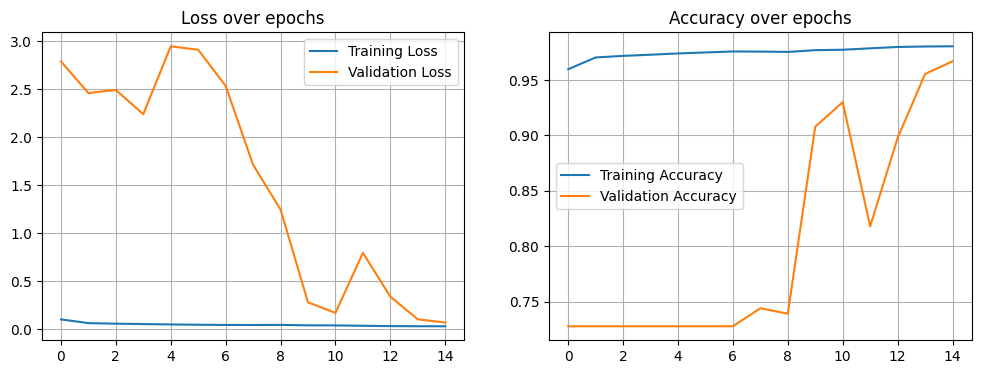

In [109]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid(True)
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid(True)
plt.title('Accuracy over epochs')

plt.show()

#####  Learning curve from model history (1 point)

In [110]:
# Function to plot learning curves 
# YOUR CODE HERE

In [111]:
# Display learning curves 
# YOUR CODE HERE

1/1 [==============================] - 0s 29ms/step


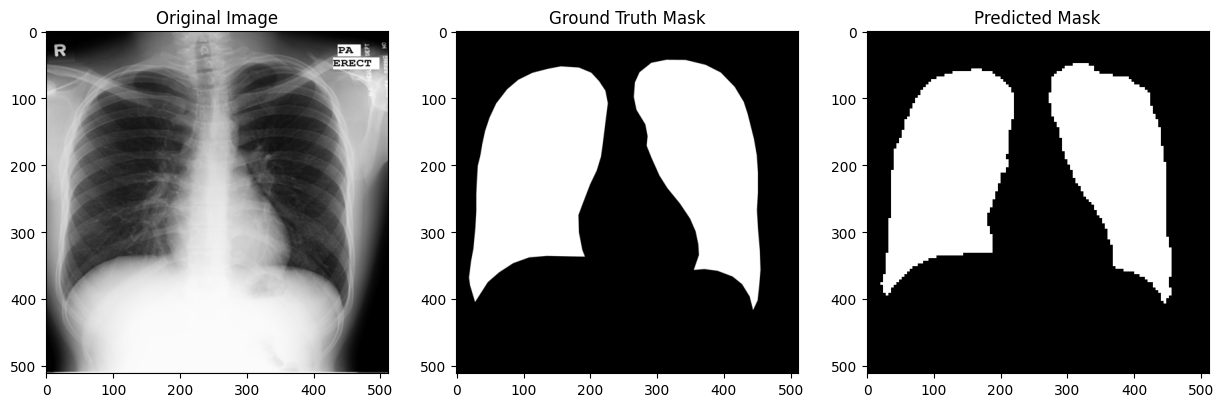

In [120]:
# Inference from model
# YOUR CODE HERE
# Select a test image file path
test_image_path = test_img_files[4]  # Replace with the desired index
# img = tf.io.read_file('testmy1.jpg')

# Read the test image
test_image = tf.io.read_file(test_image_path)
test_image = tf.image.decode_png(test_image, channels=1)
test_image = tf.repeat(test_image, [3], axis=-1)
test_image = tf.image.resize(test_image, (512, 512))
test_image = test_image / 255.0  # Normalize the image

#  It's then decoded from a PNG format into a 3-channel image tensor and 
# resized to the appropriate dimensions (512 x 512). The pixel values are normalized to be between 
# 0 and 1, which is a common practice to ensure consistent scale and better performance of the model.

# Read the corresponding ground truth mask
test_mask_path = test_mask_files[4]  # Replace with the desired index
test_mask = tf.io.read_file(test_mask_path)
test_mask = tf.image.decode_png(test_mask, channels=1)
test_mask = tf.image.resize(test_mask, (512, 512))
test_mask = test_mask / 255.0  # Normalize the mask


# The model.predict() method is used here which takes in a batch of images, so we expand 
# the dimensions of the image to simulate a batch with one image using tf.expand_dims(). 
# The model's output is a probability distribution over the classes for each pixel, and we take the 
# class with the highest probability as the predicted class for each pixel using np.argmax().

# Make a prediction on the test image
predicted_mask = model.predict(tf.expand_dims(test_image, axis=0))[0]
predicted_mask = np.argmax(predicted_mask, axis=-1)

# Plot the original image, ground truth mask, and predicted mask
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(test_image)
axes[0].set_title("Original Image")

axes[1].imshow(test_mask[:, :, 0], cmap="gray")
axes[1].set_title("Ground Truth Mask")

axes[2].imshow(predicted_mask, cmap="gray")
axes[2].set_title("Predicted Mask")

plt.show()

#### Plot the predictions

In [116]:
# YOUR CODE HERE
# model.save('my_MiniProjmodel')
# loaded_model = tf.keras.models.load_model('my_MiniProjmodel')

In [114]:
# Must Watch YT : https://www.youtube.com/watch?v=Ik85ry-Rf1g